In [1]:
#primero importamos todos los paquetes necesarios
import torch #contiene todas las funciones de PyTorch
import torch.nn as nn #contiene la clase padre de todos los modelos (nn.Module)
import torch.nn.functional as F #esencial para la función de activación 
import torchvision #fundamental para la importación de imágenes
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt #para poder representar las gráficas
import numpy as np #para las métricas de la red

#importamos también las funcioness definidas para el entrenamiento y puesta a prueba de los modelos
from modules.CNN_utilities import entrena_val, representa_test, obtiene_metricas, tester

#importamos el paquete que permite calcular el tiempo de entrenamiento
import time

C:\Users\samue\anaconda3\envs\venv_py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#establecemos el tamaño del batch, la escala de las imágenes y el número de épocas de entrenamiento
batch = 4
escala = 640
epocas = 150 #ya que tenemos activado Early Stopping

In [3]:
#a continuación definimos la operación que permitirá transformar las imágenes del repositorio en Tensores que puedan ser empleados por PyTorch
transform = transforms.Compose(
    [transforms.ToTensor(), #transforma la imagen de formato PIL a formato tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normaliza el tensor para que la media de sus valores sea 0 y su desviación estándar 0.5
     transforms.Resize((escala, escala))]) #redimensionamos las imágenes

In [4]:
#a continuación cargamos el conjunto de imágenes de train (OCT) y los dos de test (iPhone y Samsung)
OCT = ImageFolder(root = 'Datos/Classified Data/Images/OCT', transform = transform)
print(f'Tamaño del conjunto de datos de train: {len(OCT)}')

Samsung = ImageFolder(root = 'Datos/Classified Data/Images/Samsung', transform = transform)
print(f'Tamaño del conjunto de datos de test de Samsung: {len(Samsung)}')

iPhone = ImageFolder(root = 'Datos/Classified Data/Images/iPhone', transform = transform)
print(f'Tamaño del conjunto de datos de test de iPhone: {len(iPhone)}')

Tamaño del conjunto de datos de train: 113
Tamaño del conjunto de datos de test de Samsung: 93
Tamaño del conjunto de datos de test de iPhone: 99


In [5]:
#establecemos una lista con el nombre de las etiquetas
classes = OCT.classes

In [6]:
#en esta ocasión, debido a que vamos a implementar EarlyStopping es necesario dividir el conjunto de entrenamiento en train y validation
#Dividimos el conjunto de datos en entrenamiento y validación (80% y 20% respectivamente)
train_size = int(0.8 * len(OCT))
val_size = len(OCT) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(OCT, [train_size, val_size])

# Crear cargadores de datos para cada conjunto
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 4, 
    shuffle = True,
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 2
)

test_S_loader = DataLoader(
    dataset = Samsung,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

test_i_loader = DataLoader(
    dataset = iPhone,
    batch_size = 4, #establecemos un tamaño de lote (batch_size) de 10, ya que son pocas imágenes y podemos permitírnoslo
    shuffle = True, #indicamos que mezcle las imágenes
    num_workers = 2 #genera subprocesos para cargar los datos y así liberamos el proceso main
)

In [7]:
#una vez que hemos comprobado que las funciones de carga funcionan correctamente ya podemos definir el modelo
#los modelos se definen como clases que heredan todos ellos de un mismo padre: nn.Module
#las clases contienen 2 funciones básicas: __init__() y forward()
class CNN(nn.Module):
    
    def __init__(self):
        #esta función sobreescribe la función init() del padre
        super(CNN,self).__init__()
        #definimos todas las capas que van a constituir el modelo
        #una primera capa convolucional
        self.conv1 = nn.Conv2d(
            in_channels = 3, #3 canales de entrada porque las imágenes son a color
            out_channels = 6, #se trata del número de salidas de la capa. Es el número de kernels de la capa convolucional
            kernel_size = 5, #suele tratarse de un número impar
            stride = 1, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 0, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        #una segunda capa convolucional
        self.conv2 = nn.Conv2d(
            in_channels = 6, #6 canales de entrada porque es el número de salidas de la capa anterior
            out_channels = 16, #se trata del número de salidas de la capa. Es el número de kernels de la capa convolucional
            kernel_size = 5, #suele tratarse de un número impar
            stride = 1, #cantidad píxeles que se desplaza el filtro sobre la imagen
            padding = 0, #cantidad de relleno que se va a aplicar sobre los bordes de la imagen
        )
        
        #una primera capa fully-connected (red neuronal propiamente dicha)
        self.fc1 = nn.Linear(
            in_features = 16*157*157, #número de parámetros de entrada de la red (los valores se obtienen experimentalmente)
            out_features = 120 #número de neuronas de salida
        )
        
        #una segunda fully-connected
        self.fc2 = nn.Linear(120, 84)
        
        #y una tercera. Nótese que el número de neuronas de salida de la última fully-connected ha de coincidir con el número de clases
        self.fc3 = nn.Linear(84,5)
        
    def forward(self,x):
        #en esta función es donde tiene lugar la computación (y la función invocada por defecto al ejecutar la red)
        #primero aplicamos la función ReLU a la capa convolucional, que simplifica los datos. 
        #ReLU Interpreta los valores positivos como son, y los negativos los torna 0, permitiendo acelerar el entrenamiento
        #al resultado le aplicamos MaxPooling que reduce las dimensiones de los datos, seleccionando el valor máximo del kernel.
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2)
        #aplanamos la salida, hasta convertirla de forma matricial a forma vectorial (sería la capa flatten)
        x = x.view(-1,self.num_flat_features(x))#usamos una función propia de la clase para obtener el número de características
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #no incluimos una capa de LogSoft, que convierte el output en probabilidad, ya que la función loss que usaremos incluye esta funcionalidad
        return x
    
    def num_flat_features(self,x):
        #por último definimos la función que permite obtener el número de características de los tensores
        size = x.size()[1:] #seleccionamos todas las dimensiones expcepto la primera (que son los batches)
        num_features = 1
        #va iterando y calcula el número de características de los datos (x)
        for s in size:
            num_features*=s
        return num_features

#una vez definida la clase generamos una instancia de la misma
cnn = CNN()

In [8]:
#a continuación debemos entrenar el modelo, para ello es necesario definir una función loss que evalúa la desviación entre las predicciones y los valores reales
#definimos como loss la función de tipo cross entropy 
criterion = nn.CrossEntropyLoss() 

#y una función optimizadora que modificará los pesos de la red para tratar de mejorar su rendimiento
#en este caso el optimizador será la función Adam (ampliamente utilizada)
optimizer = torch.optim.Adam(params = cnn.parameters(), #los parámetros son los pesos que deberá ir actualizando el optimizador
                             lr = 0.001) #dejamos el valor de learning rate por defecto (0.001)

In [9]:
#previo al entrenamiento imprimimos por pantalla las características de la red, para poder identificar su entrenamiento
print('--------------------------------------')
print(f'Entrenamiento. Características:\n  -Capas: 2\n  -Neuronas: 120/84\n  -Early Stopping\n')

#capturamos el tiempo antes del entrenamiento
inicio = time.time()
#entrenamos el modelo con 7 épocas de paciencia
acc,loss,val_acc,val_loss = entrena_val(cnn,epocas,7,train_loader,val_loader,optimizer,criterion)
#y nuevamente calculamos el tiempo tras el entrenamiento
fin = time.time()

#ponemos a prueba la red con el conjunto de iPhone usando la función tester y recogemos los resultados para obtener las métricas
y_true_iphone, y_pred_iphone, predictions_iphone = tester(cnn,test_i_loader)
#obtenemos las métricas usando la función importada obtiene_metricas, que no las muestra por pantalla
metricas_iphone = obtiene_metricas(y_true_iphone, y_pred_iphone, predictions_iphone)

#las mostramos por pantalla
print('\n--------------------------------------')
print(f'Test. Características:\n  -Capas: 2\n  -Neuronas: 120/84\n  -Test:iphone\n')
print(f' - Matriz de confusión:\n{metricas_iphone[0]}\n - Accuracy:{metricas_iphone[1]}\n - Balanced accuracy:{metricas_iphone[2]}\n - F-score:{metricas_iphone[3]}\n - Kappa:{metricas_iphone[4]}\n - AUC:{metricas_iphone[5]}\n - Tiempo:{(fin-inicio)/60} mins')
#escribimos las métricas (a excepción de la matriz de confusión) en el archivo Resultados.csv previamente creado
with open('Resultados.csv','a') as fd:
    fd.write('\n')
    fd.write(f'OCT,Sí,No,No,RGB,Básica,2,1.0,120/84,iphone,{metricas_iphone[1]},{metricas_iphone[2]},{metricas_iphone[3]},{metricas_iphone[4]},{metricas_iphone[5]},{(fin-inicio)/60}')


#ahora ponemos a prueba la red con el conjunto de Samsung usando la función tester y recogemos los resultados para obtener las métricas
y_true_samsung, y_pred_samsung, predictions_samsung = tester(cnn,test_S_loader)
#obtenemos las métricas usando la función importada obtiene_metricas, que no las muestra por pantalla
metricas_samsung = obtiene_metricas(y_true_samsung, y_pred_samsung, predictions_samsung)
#las mostramos por pantalla
print('\n--------------------------------------')
print(f'Test. Características:\n  -Capas: 2\n  -Neuronas: 120/84\n  -Test:Samsung\n')
print(f' - Matriz de confusión:\n{metricas_samsung[0]}\n - Accuracy:{metricas_samsung[1]}\n - Balanced accuracy:{metricas_samsung[2]}\n - F-score:{metricas_samsung[3]}\n - Kappa:{metricas_samsung[4]}\n - AUC:{metricas_samsung[5]}\n - Tiempo:{(fin-inicio)/60} mins')
#escribimos las métricas (a excepción de la matriz de confusión) en el archivo Resultados.csv previamente creado
with open('Resultados.csv','a') as fd:
    fd.write('\n')
    fd.write(f'OCT,Sí,No,No,RGB,Básica,2,1.0,120/84,Samsung,{metricas_samsung[1]},{metricas_samsung[2]},{metricas_samsung[3]},{metricas_samsung[4]},{metricas_samsung[5]},{(fin-inicio)/60}')
    
#por último vamos a guardar el modelo, sus pesos y estado actual, por si se quisiera volver a emplear
torch.save(cnn.state_dict(), f'modelos/Basica/OCT_Sival_Noprep_Noinp_RGB.pth')

--------------------------------------
Entrenamiento. Características:
  -Capas: 2
  -Neuronas: 120/84
  -Early Stopping

Época 1/150 - Accuracy: 0.4222222222222222 - Loss: 0.6833776425156328
Época 1/150 - Val_accuracy: 0.7391304347826086 - Val_loss: 0.4022993782292242

Época 2/150 - Accuracy: 0.4666666666666667 - Loss: 0.38028707371817694
Época 2/150 - Val_accuracy: 0.7391304347826086 - Val_loss: 0.33946624527806823

Época 3/150 - Accuracy: 0.4888888888888889 - Loss: 0.3312562968995836
Época 3/150 - Val_accuracy: 0.4782608695652174 - Val_loss: 0.3272831543632176

Época 4/150 - Accuracy: 0.5111111111111111 - Loss: 0.30837456319067214
Época 4/150 - Val_accuracy: 0.4782608695652174 - Val_loss: 0.3396889437799868

Época 5/150 - Accuracy: 0.5666666666666667 - Loss: 0.25288702150185904
Época 5/150 - Val_accuracy: 0.30434782608695654 - Val_loss: 0.3798183254573656

Época 6/150 - Accuracy: 0.6777777777777778 - Loss: 0.2172950095600552
Época 6/150 - Val_accuracy: 0.34782608695652173 - Val_loss

Text(0.5, 1.0, 'Hola')

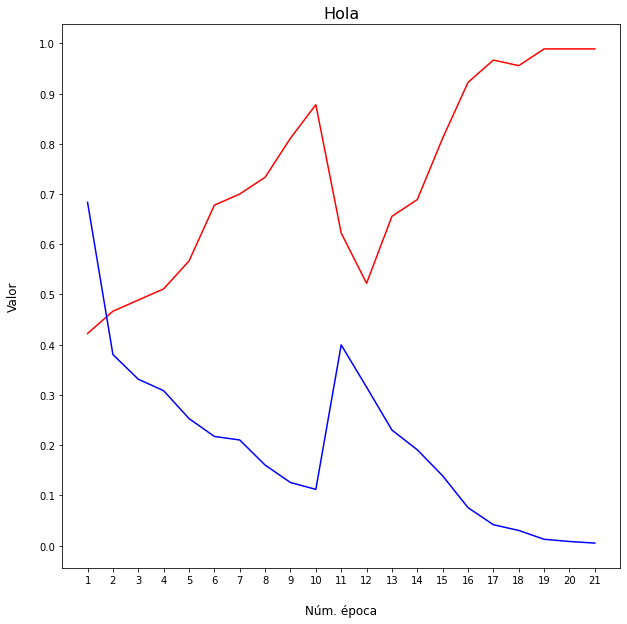

In [34]:
figura = plt.figure(figsize = (10,10))
plt.xticks(range(1,len(acc)+1))
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.plot(range(1,len(acc)+1),acc,color = 'red')
plt.plot(range(1,len(loss)+1),loss,color = 'blue')
plt.xlabel('\nNúm. época',fontsize = 12)
plt.ylabel('Valor\n',fontsize = 12)
plt.title('Hola',fontsize = 16)